<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dependencies" data-toc-modified-id="Dependencies-1">Dependencies</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2">Functions</a></span></li><li><span><a href="#Paths" data-toc-modified-id="Paths-3">Paths</a></span></li><li><span><a href="#Main" data-toc-modified-id="Main-4">Main</a></span></li><li><span><a href="#Survival-value-of-gene-modules" data-toc-modified-id="Survival-value-of-gene-modules-5">Survival value of gene modules</a></span><ul class="toc-item"><li><span><a href="#Univariable-model" data-toc-modified-id="Univariable-model-5.1">Univariable model</a></span></li></ul></li><li><span><a href="#Determine-module-membership-for-GES" data-toc-modified-id="Determine-module-membership-for-GES-6">Determine module membership for GES</a></span><ul class="toc-item"><li><span><a href="#Quick-survival-analysis-using-important-genes" data-toc-modified-id="Quick-survival-analysis-using-important-genes-6.1">Quick survival analysis using important genes</a></span></li><li><span><a href="#Multivariable-model" data-toc-modified-id="Multivariable-model-6.2">Multivariable model</a></span></li></ul></li></ul></div>

# Dependencies

In [1]:
library(survival)
library(survminer)
library(forestplot)

Loading required package: ggplot2

Loading required package: ggpubr

Loading required package: grid

Loading required package: magrittr

Loading required package: checkmate



# Functions


In [2]:
forest.fx <- function(cox_matrix, mytitle, signumber, totalnumber){
    myhrs <- cox_matrix[,c(2,6,7)]
    myhrs <- rbind(NA, myhrs)
    mytabletext <- as.data.frame(cox_matrix[,c(2,5,8)])
    mytabletext <- format(round(mytabletext, 3))
    mytabletext <- cbind(rownames(mytabletext),mytabletext)
    colnames(mytabletext) <- c("Signature", "Hazard Ratio", "p-value", "FDR")
    rownames(mytabletext) <- NULL
    mytabletext <- rbind(colnames(mytabletext), mytabletext)
    
    fn <- local({
        i = 0
        nonsig <- totalnumber - signumber
        b_clrs = c(rep("red", signumber), rep("black",nonsig))
        l_clrs = c(rep("red", signumber), rep("black",nonsig))
        function(..., clr.line, clr.marker){
            i <<- i + 1
            fpDrawNormalCI(..., clr.line = l_clrs[i], clr.marker = b_clrs[i])
        }
    })
    
    fplot <- forestplot(mytabletext, fn.ci_norm = fn, myhrs,
                        new_page = TRUE, xlog = TRUE,
                        title = mytitle, boxsize = 1)

    return(fplot)
}

# Paths

In [3]:
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/INDICATE/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/INDICATE/Plots/"

# Main

In [4]:
gene_module_th <- read.csv(file = paste0(datapath, "WGCNA/TH/gene_module_treehouse_manual_signed_20.csv"),
                                      header = T, stringsAsFactors = F,row.names = 1,check.names = F) 

In [5]:
gene_module_th <- gene_module_th[ gene_module_th$moduleColor != "grey",]
gene_module_th$moduleLabel <- paste0("TH_", gene_module_th$moduleLabel)

In [6]:
tail(gene_module_th)

,moduleLabel,moduleColor,ensembl_id_TH,ensembl_id,entrez
,<chr>,<chr>,<chr>,<chr>,<int>
ZWINT,TH_4,yellow,ENSG00000122952.16,ENSG00000122952,11130
ZXDA,TH_6,red,ENSG00000198205.6,ENSG00000198205,7789
ZXDB,TH_17,grey60,ENSG00000198455.4,ENSG00000198455,158586
ZXDC,TH_6,red,ENSG00000070476.14,ENSG00000070476,79364
ZYG11B,TH_17,grey60,ENSG00000162378.12,ENSG00000162378,79699
ZZZ3,TH_6,red,ENSG00000036549.12,ENSG00000036549,26009


In [7]:
table(gene_module_th$moduleColor)


        black         brown          cyan     darkgreen      darkgrey 
          332           228            85            44            33 
   darkorange darkturquoise        grey60    lightgreen           red 
           28            43           535            51          1162 
       salmon       skyblue         white        yellow 
           58            24            28           393 

In [8]:
length(unique(gene_module_th$moduleColor))

[1] 14

In [9]:
nrow(gene_module_th)

[1] 3044

In [10]:
GO_modules <- read.csv(file.path(datapath,"WGCNA/TH/GO_TH_cons_manual_signed_20.csv"),
                       header = T, stringsAsFactors = F, check.names = F, row.names = 1)  

In [11]:
GO_modules <- GO_modules[ GO_modules$module != "grey",]

In [12]:
GO_modules$moduleLabel <- gene_module_th$moduleLabel[match(GO_modules$module, gene_module_th$moduleColor)]

In [14]:
# Add one MF for TH_28 module
TH28_MF <- GO_modules[ GO_modules$termName == "transcription regulator activity",]

In [15]:
TH28_MF

,module,modSize,enrichmentP,BonferoniP,nModGenesInTerm,termOntology,termName,moduleLabel
,<chr>,<int>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>
GO:0140110,skyblue,24,8.2e-24,1.5e-19,24,MF,transcription regulator activity,TH_28


In [16]:
GO_modules <- GO_modules[GO_modules$termOntology == "BP",]

In [17]:
GO_modules <- rbind(GO_modules, TH28_MF)

In [18]:
dim(GO_modules)

[1] 96  8

In [19]:
GO_modules <- GO_modules[ GO_modules$nModGenesInTerm >= 9,]

In [20]:
dim(GO_modules)

[1] 85  8

In [21]:
GO_modules$myterm <- NA

for(i in unique(GO_modules$moduleLabel)){
    tmp <- GO_modules[ GO_modules$moduleLabel == i,]
    moduleterm <- tmp$termName[tmp$nModGenesInTerm == min(tmp$nModGenesInTerm)][1] #use one term if min returns two terms
    GO_modules$myterm[GO_modules$moduleLabel == i] <- moduleterm
    
}

In [22]:
head(GO_modules)

,module,modSize,enrichmentP,BonferoniP,nModGenesInTerm,termOntology,termName,moduleLabel,myterm
,<chr>,<int>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>
GO:0016050,black,331,4.6e-13,8.5e-09,31,BP,vesicle organization,TH_7,vesicle organization
GO:0010256,black,331,9.7e-12,1.8e-07,34,BP,endomembrane system organization,TH_7,vesicle organization
GO:0042886,black,331,3.1e-11,5.8e-07,80,BP,amide transport,TH_7,vesicle organization
GO:0015031,black,331,3.2e-11,5.8e-07,78,BP,protein transport,TH_7,vesicle organization
GO:0046907,black,331,7.2e-11,1.3e-06,72,BP,intracellular transport,TH_7,vesicle organization
GO:0015833,black,331,8.7e-11,1.6e-06,78,BP,peptide transport,TH_7,vesicle organization


In [23]:
dim(gene_module_th)

[1] 3044    5

In [24]:
head(GO_modules)

,module,modSize,enrichmentP,BonferoniP,nModGenesInTerm,termOntology,termName,moduleLabel,myterm
,<chr>,<int>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>
GO:0016050,black,331,4.6e-13,8.5e-09,31,BP,vesicle organization,TH_7,vesicle organization
GO:0010256,black,331,9.7e-12,1.8e-07,34,BP,endomembrane system organization,TH_7,vesicle organization
GO:0042886,black,331,3.1e-11,5.8e-07,80,BP,amide transport,TH_7,vesicle organization
GO:0015031,black,331,3.2e-11,5.8e-07,78,BP,protein transport,TH_7,vesicle organization
GO:0046907,black,331,7.2e-11,1.3e-06,72,BP,intracellular transport,TH_7,vesicle organization
GO:0015833,black,331,8.7e-11,1.6e-06,78,BP,peptide transport,TH_7,vesicle organization


In [25]:
dim(GO_modules)

[1] 85  9

# Survival value of gene modules

In [26]:
metadata <- read.csv(file.path(datapath,"IND_estimate_metadata_IHC_trb_tmb.csv"),header = T, stringsAsFactors = F, 
                     check.names = F)

expression matrix in tpm hg38

added ensg ids. see notes

In [27]:
tpm_mat <- read.csv(file = paste0(datapath, "exp_mat/INDICATE.tpm_hg38_ENSG_HUGO.csv"), 
                    header = T, stringsAsFactors = F,check.names = F) 

In [28]:
dim(tpm_mat)

[1] 26475    75

In [29]:
tpm_mat[1:10,1:10]

,ensembl_id,HGNC_symbol,go29664_ngs_rna_targrna_rnaaccess_06520001b0023r_20171125.genes.results,go29664_ngs_rna_targrna_rnaaccess_06520003c0012r_20171125.genes.results,go29664_ngs_rna_targrna_rnaaccess_06520004c0018r_20171125.genes.results,go29664_ngs_rna_targrna_rnaaccess_06520005c0017r_20171125.genes.results,go29664_ngs_rna_targrna_rnaaccess_06520006c0016r_20171125.genes.results,go29664_ngs_rna_targrna_rnaaccess_06520007c0018r_20171125.genes.results,go29664_ngs_rna_targrna_rnaaccess_06520008c0017r_20171125.genes.results,go29664_ngs_rna_targrna_rnaaccess_06520010b0023r_20171125.genes.results
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000121410.11,A1BG,0.06,1.23,0.69,0.36,0.32,0.76,0.00,2.46
2,ENSG00000268895.5,A1BG-AS1,0.14,1.41,1.21,1.36,0.38,0.55,0.00,0.77
3,ENSG00000148584.14,A1CF,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,ENSG00000175899.14,A2M,114.92,98.31,50.73,30.12,35.55,384.47,212.23,71.93
5,ENSG00000245105.2,A2M-AS1,0.10,1.07,0.49,0.87,0.43,0.58,0.00,0.49
6,ENSG00000166535.19,A2ML1,0.00,0.00,0.00,0.04,0.02,0.00,0.00,3.73
7,ENSG00000256069.7,A2MP1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,ENSG00000184389.9,A3GALT2,0.10,0.00,0.02,0.02,0.00,0.02,0.00,0.00
9,ENSG00000128274.15,A4GALT,2.81,8.51,6.03,0.79,0.86,1.27,0.02,2.80


In [30]:
indicate_ids <- tpm_mat[,1:2]

Remove samples with no ensg id to compare with TH data and remove HGNC

In [31]:
tpm_mat_ensg <- tpm_mat[!is.na(tpm_mat$ensembl_id),]

In [32]:
dim(tpm_mat_ensg)

[1] 24447    75

remove hugos add ensembl ids as rownames

In [33]:
tpm_mat_ensg$HGNC_symbol <- NULL
rownames(tpm_mat_ensg) <- gsub("[.].*", "",tpm_mat_ensg$ensembl_id)
tpm_mat_ensg$ensembl_id <- NULL

In [34]:
tpm_mat_ensg[1:10,1:10]

,go29664_ngs_rna_targrna_rnaaccess_06520001b0023r_20171125.genes.results,go29664_ngs_rna_targrna_rnaaccess_06520003c0012r_20171125.genes.results,go29664_ngs_rna_targrna_rnaaccess_06520004c0018r_20171125.genes.results,go29664_ngs_rna_targrna_rnaaccess_06520005c0017r_20171125.genes.results,go29664_ngs_rna_targrna_rnaaccess_06520006c0016r_20171125.genes.results,go29664_ngs_rna_targrna_rnaaccess_06520007c0018r_20171125.genes.results,go29664_ngs_rna_targrna_rnaaccess_06520008c0017r_20171125.genes.results,go29664_ngs_rna_targrna_rnaaccess_06520010b0023r_20171125.genes.results,go29664_ngs_rna_targrna_rnaaccess_06520011b0023r_20171125.genes.results,go29664_ngs_rna_targrna_rnaaccess_06520015c0016r_20171125.genes.results
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000121410,0.06,1.23,0.69,0.36,0.32,0.76,0.00,2.46,1.27,0.54
ENSG00000268895,0.14,1.41,1.21,1.36,0.38,0.55,0.00,0.77,0.64,0.52
ENSG00000148584,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
ENSG00000175899,114.92,98.31,50.73,30.12,35.55,384.47,212.23,71.93,32.14,302.78
ENSG00000245105,0.10,1.07,0.49,0.87,0.43,0.58,0.00,0.49,0.15,0.16
ENSG00000166535,0.00,0.00,0.00,0.04,0.02,0.00,0.00,3.73,4.06,2.20
ENSG00000256069,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
ENSG00000184389,0.10,0.00,0.02,0.02,0.00,0.02,0.00,0.00,0.05,0.04
ENSG00000128274,2.81,8.51,6.03,0.79,0.86,1.27,0.02,2.80,5.23,12.09


In [35]:
dim(tpm_mat_ensg)

[1] 24447    73

transpose and clean up sample IDs

In [36]:
tpm_mat_ensg_t <- t(tpm_mat_ensg)

In [37]:
rownames(tpm_mat_ensg_t) <- gsub(".*rnaaccess_", "", rownames(tpm_mat_ensg_t))
rownames(tpm_mat_ensg_t) <- gsub("_.*", "", rownames(tpm_mat_ensg_t))
rownames(tpm_mat_ensg_t) <- toupper(rownames(tpm_mat_ensg_t))

log2 transform

In [38]:
tpm_mat_ensg_t <- log2(tpm_mat_ensg_t + 1)

In [39]:
dim(tpm_mat_ensg_t)

[1]    73 24447

match samples with those in metadata

In [40]:
tpm_mat_ensg_t_matched <- tpm_mat_ensg_t[rownames(tpm_mat_ensg_t) %in% metadata$sample_id,]

In [41]:
dim(tpm_mat_ensg_t_matched)

[1]    66 24447

module label cleanup

In [42]:
head(gene_module_th)

,moduleLabel,moduleColor,ensembl_id_TH,ensembl_id,entrez
,<chr>,<chr>,<chr>,<chr>,<int>
A2M,TH_22,darkgreen,ENSG00000175899.14,ENSG00000175899,2
AAK1,TH_7,black,ENSG00000115977.18,ENSG00000115977,22848
AASDH,TH_6,red,ENSG00000157426.13,ENSG00000157426,132949
AASDHPPT,TH_6,red,ENSG00000149313.10,ENSG00000149313,60496
ABCB10,TH_6,red,ENSG00000135776.4,ENSG00000135776,23456
ABCE1,TH_6,red,ENSG00000164163.10,ENSG00000164163,6059


In [43]:
dim(gene_module_th)

[1] 3044    5

In [44]:
mygene_modules <- gene_module_th[ gene_module_th$ensembl_id %in% colnames(tpm_mat_ensg_t_matched),]

In [45]:
dim(mygene_modules)

[1] 3033    5

In [46]:
#genes that were in imatrix data but not in treehouse
gene_module_th[!rownames(gene_module_th) %in% rownames(mygene_modules),]

,moduleLabel,moduleColor,ensembl_id_TH,ensembl_id,entrez
,<chr>,<chr>,<chr>,<chr>,<int>
BMS1P4,TH_6,red,ENSG00000242338.6,ENSG00000242338,NA
ECSCR,TH_22,darkgreen,ENSG00000249751.3,ENSG00000249751,641700
KAT6B,TH_6,red,ENSG00000156650.12,ENSG00000156650,23522
KIAA1143,TH_6,red,ENSG00000163807.5,ENSG00000163807,57456
KIF15,TH_4,yellow,ENSG00000163808.16,ENSG00000163808,56992
MATR3,TH_6,red,ENSG00000015479.17,ENSG00000015479,9782
RCC2,TH_4,yellow,ENSG00000179051.13,ENSG00000179051,55920
SLC16A1,TH_4,yellow,ENSG00000155380.11,ENSG00000155380,6566
ZKSCAN7,TH_6,red,ENSG00000196345.12,ENSG00000196345,55888


## Univariable model

Make a gene signature matrix for all samples

In [47]:
#Order same as heatmap
labelorders <- c('TH_4','TH_18','TH_17','TH_28','TH_6','TH_7','TH_14',
                 'TH_24','TH_23','TH_27','TH_3','TH_13','TH_22','TH_26')

In [48]:
module_sample <- matrix(ncol = nrow(tpm_mat_ensg_t_matched), nrow = length(unique(mygene_modules$moduleLabel)))
rownames(module_sample) <- labelorders
colnames(module_sample) <- rownames(tpm_mat_ensg_t_matched)

In [49]:
for(mod in 1:nrow(module_sample)){
    mymod <- rownames(module_sample)[mod]    
    modGenes <- mygene_modules$ensembl_id[which(mygene_modules$moduleLabel == mymod)]
    genes <- tpm_mat_ensg_t_matched[,modGenes]
if(length(modGenes) > 1){
    averagegenes <- apply(genes,1,mean)
    module_sample[mod,] <- averagegenes}
}

In [50]:
dim(module_sample)

[1] 14 66

Merge with metadata for survival analysis

In [51]:
module_sample_t <- as.data.frame(t(module_sample))
module_sample_t$sample_id <- rownames(module_sample_t)

In [52]:
metadata_modules <- merge(metadata, module_sample_t, by = "sample_id")

Run cox and make a summary matrix

In [53]:
module_cox <- matrix(nrow = nrow(module_sample), ncol = 7)
rownames(module_cox) <- rownames(module_sample)
colnames(module_cox) <- c('coef', 'exp(coef)', 'se(coef)', 'z', 'Pr(>|z|)', 'lower.95' ,'upper.95')

In [54]:
for(i in rownames(module_cox)){
   # message(i)
    f <- as.formula(paste0("Surv(TRTDUR, progressed)~", i))  
    coxmodel <- coxph(f, data=metadata_modules) 
    sumcox <- summary(coxmodel)
   # print(sumcox)
    module_cox[i,1:5] <- sumcox$coefficients[1,1:5]
    module_cox[i,6:7] <- sumcox$conf.int[1,3:4]
}

Calculate FDR add to matrix

In [55]:
fdr_df <- as.matrix(p.adjust(module_cox[,5], method = "fdr"))
colnames(fdr_df)[1] <- "fdr"
module_cox <- cbind(module_cox, fdr_df)

In [56]:
module_cox

,coef,exp(coef),se(coef),z,Pr(>|z|),lower.95,upper.95,fdr
TH_4,0.26275994,1.3005145,0.2341486,1.12219311,0.261780341,0.8218784,2.0578932,0.61082080
TH_18,-0.04886734,0.9523075,0.2950671,-0.16561433,0.868460466,0.5340914,1.6980041,0.93526512
TH_17,-0.21641351,0.8054022,0.3312179,-0.65338721,0.513506685,0.4208038,1.5415086,0.68908419
TH_28,-0.17251042,0.8415495,0.2824973,-0.61066211,0.541423293,0.4837461,1.4640026,0.68908419
TH_6,-0.16634058,0.8467578,0.3421508,-0.48616163,0.626852576,0.4330319,1.6557642,0.73132800
TH_7,-0.29204773,0.7467329,0.3107780,-0.93973113,0.347355493,0.4060978,1.3730930,0.68908419
TH_14,-0.19463045,0.8231388,0.2841113,-0.68504997,0.493312389,0.4716687,1.4365114,0.68908419
TH_24,-0.01897856,0.9812004,0.2896798,-0.06551567,0.947763434,0.5561371,1.7311455,0.94776343
TH_23,0.14233871,1.1529671,0.1923932,0.73983248,0.459401648,0.7907725,1.6810563,0.68908419
TH_27,-0.33939059,0.7122042,0.1164899,-2.91347644,0.003574288,0.5668239,0.8948720,0.02087031


Make a manual list of module labels and go terms

In [57]:
module_cox <- as.data.frame(module_cox)

In [58]:
module_cox

,coef,exp(coef),se(coef),z,Pr(>|z|),lower.95,upper.95,fdr
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TH_4,0.26275994,1.3005145,0.2341486,1.12219311,0.261780341,0.8218784,2.0578932,0.61082080
TH_18,-0.04886734,0.9523075,0.2950671,-0.16561433,0.868460466,0.5340914,1.6980041,0.93526512
TH_17,-0.21641351,0.8054022,0.3312179,-0.65338721,0.513506685,0.4208038,1.5415086,0.68908419
TH_28,-0.17251042,0.8415495,0.2824973,-0.61066211,0.541423293,0.4837461,1.4640026,0.68908419
TH_6,-0.16634058,0.8467578,0.3421508,-0.48616163,0.626852576,0.4330319,1.6557642,0.73132800
TH_7,-0.29204773,0.7467329,0.3107780,-0.93973113,0.347355493,0.4060978,1.3730930,0.68908419
TH_14,-0.19463045,0.8231388,0.2841113,-0.68504997,0.493312389,0.4716687,1.4365114,0.68908419
TH_24,-0.01897856,0.9812004,0.2896798,-0.06551567,0.947763434,0.5561371,1.7311455,0.94776343
TH_23,0.14233871,1.1529671,0.1923932,0.73983248,0.459401648,0.7907725,1.6810563,0.68908419


In [59]:
module_cox$term <- NA

module_cox$term <- GO_modules$myterm[match(rownames(module_cox),GO_modules$moduleLabel)]

In [60]:
module_cox

,coef,exp(coef),se(coef),z,Pr(>|z|),lower.95,upper.95,fdr,term
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
TH_4,0.26275994,1.3005145,0.2341486,1.12219311,0.261780341,0.8218784,2.0578932,0.61082080,DNA replication
TH_18,-0.04886734,0.9523075,0.2950671,-0.16561433,0.868460466,0.5340914,1.6980041,0.93526512,mRNA metabolic process
TH_17,-0.21641351,0.8054022,0.3312179,-0.65338721,0.513506685,0.4208038,1.5415086,0.68908419,cellular protein modification process
TH_28,-0.17251042,0.8415495,0.2824973,-0.61066211,0.541423293,0.4837461,1.4640026,0.68908419,transcription regulator activity
TH_6,-0.16634058,0.8467578,0.3421508,-0.48616163,0.626852576,0.4330319,1.6557642,0.73132800,RNA metabolic process
TH_7,-0.29204773,0.7467329,0.3107780,-0.93973113,0.347355493,0.4060978,1.3730930,0.68908419,vesicle organization
TH_14,-0.19463045,0.8231388,0.2841113,-0.68504997,0.493312389,0.4716687,1.4365114,0.68908419,cellular protein localization
TH_24,-0.01897856,0.9812004,0.2896798,-0.06551567,0.947763434,0.5561371,1.7311455,0.94776343,RNA splicing
TH_23,0.14233871,1.1529671,0.1923932,0.73983248,0.459401648,0.7907725,1.6810563,0.68908419,SRP-dependent cotranslational protein targeting to membrane


In [61]:
# some cleanup for terms

module_cox$term[module_cox$term == "antigen processing and presentation of exogenous peptide antigen via MHC class I, TAP-dependent" ] <- 
"antigen processing and presentation"
module_cox$term[module_cox$term == "SRP-dependent cotranslational protein targeting to membrane" ] <- "protein targeting to ER"

In [62]:
write.csv(module_cox, file = "~/OneDrive - UHN/Documents/Manuscripts/INDICATE/v2/TableS7.csv")

In [63]:
hrs <- module_cox[,c(2,6,7)]
hrs <- rbind(NA,hrs)

In [64]:
hrs

,exp(coef),lower.95,upper.95
,<dbl>,<dbl>,<dbl>
1,NA,NA,NA
TH_4,1.3005145,0.8218784,2.0578932
TH_18,0.9523075,0.5340914,1.6980041
TH_17,0.8054022,0.4208038,1.5415086
TH_28,0.8415495,0.4837461,1.4640026
TH_6,0.8467578,0.4330319,1.6557642
TH_7,0.7467329,0.4060978,1.3730930
TH_14,0.8231388,0.4716687,1.4365114
TH_24,0.9812004,0.5561371,1.7311455


In [65]:
tabtext <- as.data.frame(module_cox[,c(2,5,8)])
tabtext <- format(round(tabtext, 2))
tabtext <- cbind(module_cox[,9],tabtext)
colnames(tabtext) <- c("Signature", "Hazard Ratio", "p-value", "FDR")
rownames(tabtext) <- NULL
tabtext <- rbind(colnames(tabtext),tabtext)

In [66]:
tabtext

Signature,Hazard Ratio,p-value,FDR
<chr>,<I<chr>>,<I<chr>>,<I<chr>>
Signature,Hazard Ratio,p-value,FDR
DNA replication,1.30,0.26,0.61
mRNA metabolic process,0.95,0.87,0.94
cellular protein modification process,0.81,0.51,0.69
transcription regulator activity,0.84,0.54,0.69
RNA metabolic process,0.85,0.63,0.73
vesicle organization,0.75,0.35,0.69
cellular protein localization,0.82,0.49,0.69
RNA splicing,0.98,0.95,0.95


In [67]:
tabtext$`Hazard Ratio` <- NULL

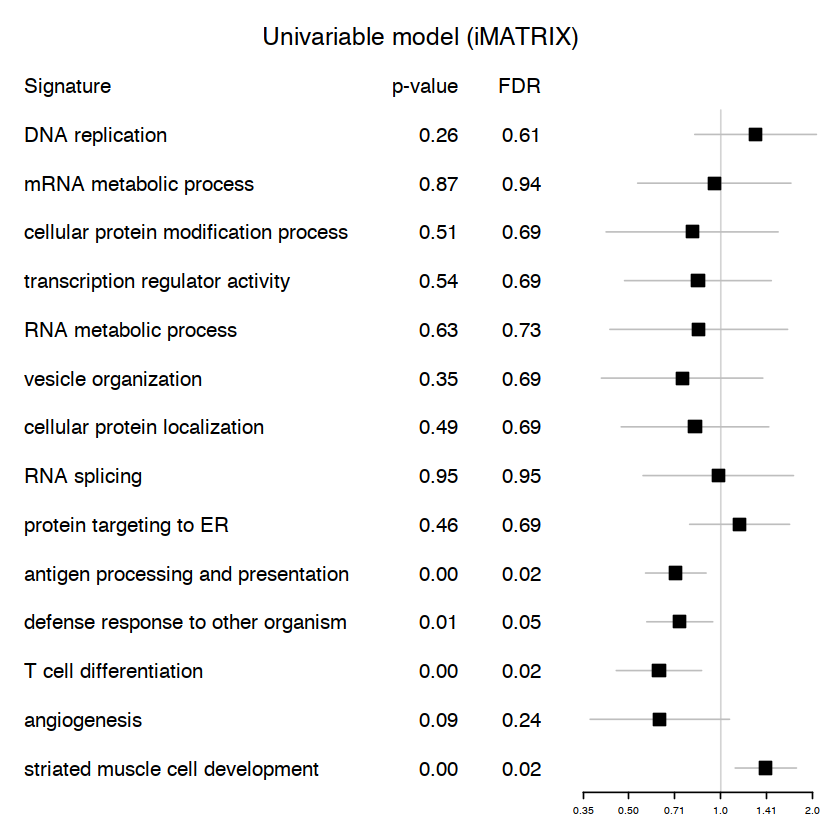

In [68]:
fplot <- forestplot(tabtext, hrs, new_page = TRUE, xlog = TRUE,
                   title = "Univariable model (iMATRIX)", boxsize = 0.25)

In [69]:
pdf(file = paste0(plotpath,"Univar_forestplot.pdf"),
    width = 7, height = 10,
    useDingbats = FALSE, onefile = F)

forestplot(tabtext, hrs, new_page = TRUE, xlog = TRUE,
                   title = "Univariable model (iMATRIX)", boxsize = 0.25)

dev.off()

pdf 
  2

# Determine module membership for GES

In [70]:
library(WGCNA)

Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: ‘fastcluster’


The following object is masked from ‘package:stats’:

    hclust





Attaching package: ‘WGCNA’


The following object is masked from ‘package:stats’:

    cor




In [71]:
mountpath <- "/Users/anabbi/Desktop/H4H/INDICATE/wgcna/th/"

In [72]:
load(paste0(mountpath, "Consensus_Network_TH_manual_signed_20.RData"))

In [73]:
load(file = paste0(datapath, "WGCNA/TH/Consensus-dataInput_Treehouse_tpm.RData"))

In [74]:
gene_module <- read.csv(file = paste0(datapath, "/WGCNA/TH/gene_module_treehouse_manual_signed_20.csv"),
                       header = T, stringsAsFactors = F,row.names = 1,check.names = F) 

In [75]:
GO_module <- read.csv(file = paste0(datapath, "WGCNA/TH/GO_TH_cons_manual_signed_20.csv"),
                       header = T, stringsAsFactors = F,row.names = 1,check.names = F) 

In [76]:
head(GO_module)

,module,modSize,enrichmentP,BonferoniP,nModGenesInTerm,termOntology,termName
,<chr>,<int>,<dbl>,<dbl>,<int>,<chr>,<chr>
GO:0000139,black,331,3.6e-14,6.6e-10,49,CC,Golgi membrane
GO:0005794,black,331,1.9e-13,3.5e-09,73,CC,Golgi apparatus
GO:0016050,black,331,4.6e-13,8.5e-09,31,BP,vesicle organization
GO:0031090,black,331,8.8e-13,1.6e-08,120,CC,organelle membrane
GO:0012505,black,331,4.0e-12,7.3e-08,140,CC,endomembrane system
GO:0010256,black,331,9.7e-12,1.8e-07,34,BP,endomembrane system organization


In [77]:
# add module labels to GO data
labels_colors <- gene_module[ !duplicated(gene_module$moduleColor),c("moduleLabel", "moduleColor")]
GO_module$label <- NA
for(i in 1:nrow(labels_colors)){
    mycolor <- labels_colors$moduleColor[i]
    GO_module$label[GO_module$module == mycolor] <- labels_colors$moduleLabel[labels_colors$moduleColor == mycolor]
    }

In [78]:
GO_module[ GO_module$label == 3,]

,module,modSize,enrichmentP,BonferoniP,nModGenesInTerm,termOntology,termName,label
,<chr>,<int>,<dbl>,<dbl>,<int>,<chr>,<chr>,<int>
GO:0006955,brown,224,2.5e-99,4.5e-95,155,BP,immune response,3
GO:0002376,brown,224,1.7e-82,3.1e-78,164,BP,immune system process,3
GO:0002682,brown,224,2.0e-61,3.6e-57,112,BP,regulation of immune system process,3
GO:0001775,brown,224,2.9e-59,5.2e-55,107,BP,cell activation,3
GO:0006952,brown,224,3.6e-59,6.6e-55,111,BP,defense response,3
GO:0045321,brown,224,1.5e-58,2.7e-54,102,BP,leukocyte activation,3
GO:0050776,brown,224,1.5e-56,2.7e-52,88,BP,regulation of immune response,3
GO:0051707,brown,224,9.0e-46,1.7e-41,92,BP,response to other organism,3
GO:0043207,brown,224,1.0e-45,1.9e-41,92,BP,response to external biotic stimulus,3


In [79]:
modNames <- substring(names(consMEs[[1]]$data), 3)

In [80]:
length(consMEs)

[1] 7

In [81]:
geneInfo <- gene_module

In [82]:
for(c in 1:length(consMEs)){
    #for each cancer, correlate genes with module eigengenes
    geneModuleMembership <- as.data.frame(cor(treehouse_gene_mat[[c]]$data, consMEs[[c]]$data, use = "p"))
    MMPvalue <- as.data.frame(corPvalueStudent(as.matrix(geneModuleMembership), nSamples[c]))
    #add cancer index to colnames
    names(geneModuleMembership) <- paste0("MM_TH", modNames, "_", c)
    names(MMPvalue) <- paste0("p.MM_TH", modNames, "_", c)
    
    geneInfo <- data.frame(geneInfo, geneModuleMembership[rownames(geneInfo),],
                           MMPvalue[rownames(geneInfo), ])
}

In [83]:
geneInfo <- geneInfo[ geneInfo$moduleLabel != 0,]

In [84]:
geneInfo$moduleLabel <- as.character(geneInfo$moduleLabel)

In [85]:
tables8 <- geneInfo[, !grepl("TH0", colnames(geneInfo))]
tables8$moduleLabel <- paste0("TH_", tables8$moduleLabel)

write.csv(tables8, file = "~/OneDrive - UHN/Documents/Manuscripts/INDICATE/v2/TableS8.csv")

In [86]:
#Antigen presentation module
TH_27 <- geneInfo[ geneInfo$moduleLabel == "27",]

In [87]:
rownames(geneInfo)[ geneInfo$moduleLabel == "13"]

[1] "ARHGAP9"   "C11orf21"  "C16orf54"  "CCL17"     "CCL22"     "CCL5"     
 [7] "CCR4"      "CCR7"      "CD2"       "CD244"     "CD247"     "CD27"     
[13] "CD3D"      "CD3E"      "CD3G"      "CD5"       "CD8A"      "CD96"     
[19] "CHRM3-AS2" "CLEC9A"    "CRTAM"     "CST7"      "CTSW"      "CXCL9"    
[25] "CXCR3"     "CXCR6"     "EOMES"     "FASLG"     "FCER2"     "FCRL6"    
[31] "GPR171"    "GZMA"      "GZMH"      "GZMK"      "ICOS"      "IFNG"     
[37] "IL7R"      "ITK"       "KIAA0125"  "KIR3DL2"   "LINC00861" "LINC00892"
[43] "NKG7"      "P2RY10"    "PARVG"     "PRF1"      "RGL4"      "SAMD3"    
[49] "SH2D1A"    "SIRPG"     "SLA2"      "SLAMF1"    "THEMIS"    "TRAT1"    
[55] "UBASH3A"   "UBD"       "XCL2"      "ZNF683"

In [88]:
rownames(geneInfo)[ geneInfo$moduleLabel == "26"]

[1] "ACTC1"  "ASB5"   "CAV3"   "CHRNA1" "CHRND"  "CKM"    "CSRP3"  "DES"   
 [9] "DUSP13" "DUSP27" "HSPB3"  "KLHL30" "KLHL40" "KLHL41" "MYF6"   "MYL1"  
[17] "MYL2"   "MYOG"   "MYOM3"  "MYOZ2"  "MYPN"   "NRAP"   "RAPSN"  "RPL3L" 
[25] "SGCA"   "SLN"    "SMYD1"  "TRDN"

In [89]:
rownames(TH_27)

[1] "ACSL5"     "APOL1"     "APOL3"     "APOL6"     "B2M"       "CARD16"   
 [7] "CASP1"     "ETV7"      "GBP4"      "HCP5"      "HLA-A"     "HLA-B"    
[13] "HLA-C"     "HLA-E"     "HLA-F"     "IFIH1"     "LAPTM5"    "MLKL"     
[19] "NLRC5"     "PSMB8"     "PSMB8-AS1" "PSMB9"     "RARRES3"   "RTP4"     
[25] "SP100"     "TAP1"      "TNFRSF14"  "WAS"

In [90]:
TH_27[ order(TH_27$MM_TH27_1, TH_27$MM_TH27_2, TH_27$MM_TH27_3, TH_27$MM_TH27_4,
            TH_27$MM_TH27_5, TH_27$MM_TH27_6,TH_27$MM_TH27_7),grepl("MM_TH27", colnames(TH_27))]

,MM_TH27_1,p.MM_TH27_1,MM_TH27_2,p.MM_TH27_2,MM_TH27_3,p.MM_TH27_3,MM_TH27_4,p.MM_TH27_4,MM_TH27_5,p.MM_TH27_5,MM_TH27_6,p.MM_TH27_6,MM_TH27_7,p.MM_TH27_7
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LAPTM5,0.4784209,2.092838e-02,0.8617827,1.313379e-57,0.6310685,2.231517e-19,0.8441176,5.436001e-43,0.7169507,2.830747e-07,0.6499992,9.527110e-16,0.5673396,4.543053e-07
PSMB8-AS1,0.5547759,6.005319e-03,0.9325617,1.460143e-85,0.8516176,9.608027e-47,0.9055033,1.841631e-58,0.9060352,2.175923e-15,0.8576079,7.152555e-36,0.9103788,5.451247e-27
APOL6,0.6553104,6.887068e-04,0.8862256,4.516399e-65,0.6858457,7.531348e-24,0.8984263,3.384139e-56,0.8598669,2.360741e-12,0.8638696,6.099290e-37,0.8004522,2.587126e-16
WAS,0.7422929,5.004731e-05,0.8660911,8.155604e-59,0.7294137,3.550405e-28,0.8502012,3.364909e-44,0.6829858,1.663347e-06,0.6973403,8.924421e-19,0.5770431,2.593790e-07
NLRC5,0.7701540,1.722331e-05,0.8396377,5.463317e-52,0.7878578,1.651709e-35,0.8751628,8.719083e-50,0.9011581,5.318741e-15,0.8741351,8.166018e-39,0.8661308,1.487272e-21
PSMB8,0.7980427,5.058771e-06,0.9488286,1.487312e-96,0.7990554,3.505794e-37,0.9432955,1.094455e-74,0.8506193,7.092905e-12,0.7254462,7.202411e-21,0.9097678,6.754050e-27
B2M,0.8041640,3.769433e-06,0.9292156,1.208525e-83,0.8758868,1.651636e-52,0.9351672,2.118461e-70,0.9223499,7.355391e-17,0.8588473,4.435387e-36,0.6395902,4.328931e-09
SP100,0.8219610,1.507335e-06,0.9132166,1.291460e-75,0.5498557,3.502764e-14,0.8385037,6.386632e-42,0.7698224,1.013963e-08,0.7930400,3.654084e-27,0.8230885,7.156320e-18
ACSL5,0.8238461,1.359900e-06,0.9008197,2.138484e-70,0.8072974,1.754365e-38,0.9000664,1.046860e-56,0.7749583,7.003941e-09,0.7738787,3.686978e-25,0.6473374,2.441307e-09


In [91]:
mm27_1 <- rownames(TH_27)[TH_27$MM_TH27_1 > 0.8]
mm27_2 <- rownames(TH_27)[TH_27$MM_TH27_2 > 0.8]
mm27_3 <- rownames(TH_27)[TH_27$MM_TH27_3 > 0.8]
mm27_4 <- rownames(TH_27)[TH_27$MM_TH27_4 > 0.8]
mm27_5 <- rownames(TH_27)[TH_27$MM_TH27_5 > 0.8]
mm27_6 <- rownames(TH_27)[TH_27$MM_TH27_6 > 0.8]
mm27_7 <- rownames(TH_27)[TH_27$MM_TH27_7 > 0.8]

In [92]:
Reduce(intersect, list(mm27_1, mm27_2, mm27_3 ,mm27_4,mm27_5,mm27_6,mm27_7))

[1] "HLA-B" "HLA-F" "PSMB9"

In [93]:
# T cell activation
TH_13 <- geneInfo[ geneInfo$moduleLabel == "13",]

In [94]:
rownames(TH_13)

[1] "ARHGAP9"   "C11orf21"  "C16orf54"  "CCL17"     "CCL22"     "CCL5"     
 [7] "CCR4"      "CCR7"      "CD2"       "CD244"     "CD247"     "CD27"     
[13] "CD3D"      "CD3E"      "CD3G"      "CD5"       "CD8A"      "CD96"     
[19] "CHRM3-AS2" "CLEC9A"    "CRTAM"     "CST7"      "CTSW"      "CXCL9"    
[25] "CXCR3"     "CXCR6"     "EOMES"     "FASLG"     "FCER2"     "FCRL6"    
[31] "GPR171"    "GZMA"      "GZMH"      "GZMK"      "ICOS"      "IFNG"     
[37] "IL7R"      "ITK"       "KIAA0125"  "KIR3DL2"   "LINC00861" "LINC00892"
[43] "NKG7"      "P2RY10"    "PARVG"     "PRF1"      "RGL4"      "SAMD3"    
[49] "SH2D1A"    "SIRPG"     "SLA2"      "SLAMF1"    "THEMIS"    "TRAT1"    
[55] "UBASH3A"   "UBD"       "XCL2"      "ZNF683"

In [95]:
TH_13[ order(TH_13$MM_TH13_1, TH_13$MM_TH13_2, TH_13$MM_TH13_3, TH_13$MM_TH13_4,
            TH_13$MM_TH13_5, TH_13$MM_TH13_6,TH_13$MM_TH13_7),grepl("MM_TH13", colnames(TH_13))]

,MM_TH13_1,p.MM_TH13_1,MM_TH13_2,p.MM_TH13_2,MM_TH13_3,p.MM_TH13_3,MM_TH13_4,p.MM_TH13_4,MM_TH13_5,p.MM_TH13_5,MM_TH13_6,p.MM_TH13_6,MM_TH13_7,p.MM_TH13_7
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
KIR3DL2,0.2928406,1.750850e-01,0.5961463,9.168345e-20,0.7546816,4.302378e-31,0.8010890,1.056355e-35,0.6445282,9.501857e-06,0.6271907,1.798247e-14,0.7617006,4.624310e-14
CD27,0.3887011,6.679717e-02,0.9394872,7.259575e-90,0.9300237,1.867931e-71,0.9159417,3.776241e-62,0.9682396,7.137122e-24,0.8010313,4.607697e-28,0.9416750,6.292625e-33
ARHGAP9,0.4323493,3.936216e-02,0.8871212,2.236080e-65,0.6222811,9.652831e-19,0.5805010,2.999639e-15,0.8276579,8.135175e-11,0.7087196,1.358396e-19,0.6386558,4.633545e-09
CXCL9,0.4896524,1.771353e-02,0.7644230,7.058594e-38,0.7621461,5.051546e-32,0.8032955,4.952968e-36,0.8721239,4.838125e-13,0.7033422,3.343419e-19,0.7953219,5.475132e-16
C11orf21,0.4939824,1.658661e-02,0.8758176,1.059797e-61,0.5013089,1.085373e-11,0.6983034,7.795684e-24,0.9064579,2.009135e-15,0.6177890,5.634279e-14,0.7931679,7.453310e-16
KIAA0125,0.5425543,7.476983e-03,0.7755066,1.323590e-39,0.6095551,7.430401e-18,0.7973482,3.733719e-35,0.5983046,5.749355e-05,0.5186062,1.299252e-09,0.7615974,4.682387e-14
CCL17,0.5595308,5.502226e-03,0.5551211,7.840582e-17,0.5002888,1.212840e-11,0.6963699,1.164886e-23,0.6915607,1.087933e-06,0.5995098,4.668746e-13,0.4961645,1.686427e-05
CHRM3-AS2,0.6214728,1.548854e-03,0.7553319,1.569672e-36,0.4480449,2.252428e-09,0.7236566,2.941922e-26,0.6408066,1.110530e-05,0.4084243,3.641930e-06,0.7899685,1.170649e-15
PRF1,0.6254051,1.416362e-03,0.9045746,6.688545e-72,0.8314390,1.101908e-42,0.7979602,3.042385e-35,0.8298756,6.530872e-11,0.6633603,1.512815e-16,0.8983189,2.888580e-25


In [96]:
mm13_1 <- rownames(TH_13)[TH_13$MM_TH13_1 > 0.8]
mm13_2 <- rownames(TH_13)[TH_13$MM_TH13_2 > 0.8]
mm13_3 <- rownames(TH_13)[TH_13$MM_TH13_3 > 0.8]
mm13_4 <- rownames(TH_13)[TH_13$MM_TH13_4 > 0.8]
mm13_5 <- rownames(TH_13)[TH_13$MM_TH13_5 > 0.8]
mm13_6 <- rownames(TH_13)[TH_13$MM_TH13_6 > 0.8]
mm13_7 <- rownames(TH_13)[TH_13$MM_TH13_7 > 0.8]

In [97]:
Reduce(intersect, list(mm13_1, mm13_2, mm13_3 ,mm13_4,mm13_5,mm13_6,mm13_7))

[1] "CD2"     "CD3D"    "CD3E"    "CD3G"    "CXCR3"   "THEMIS"  "UBASH3A"

In [98]:
# Muscle dev
TH_26 <- geneInfo[ geneInfo$moduleLabel == "26",]

In [99]:
rownames(TH_26)

[1] "ACTC1"  "ASB5"   "CAV3"   "CHRNA1" "CHRND"  "CKM"    "CSRP3"  "DES"   
 [9] "DUSP13" "DUSP27" "HSPB3"  "KLHL30" "KLHL40" "KLHL41" "MYF6"   "MYL1"  
[17] "MYL2"   "MYOG"   "MYOM3"  "MYOZ2"  "MYPN"   "NRAP"   "RAPSN"  "RPL3L" 
[25] "SGCA"   "SLN"    "SMYD1"  "TRDN"

In [100]:
TH_26[ order(TH_26$MM_TH26_1, TH_26$MM_TH26_2, TH_26$MM_TH26_3, TH_26$MM_TH26_4,
            TH_26$MM_TH26_5, TH_26$MM_TH26_6,TH_26$MM_TH26_7),grepl("MM_TH26", colnames(TH_26))]

,MM_TH26_1,p.MM_TH26_1,MM_TH26_2,p.MM_TH26_2,MM_TH26_3,p.MM_TH26_3,MM_TH26_4,p.MM_TH26_4,MM_TH26_5,p.MM_TH26_5,MM_TH26_6,p.MM_TH26_6,MM_TH26_7,p.MM_TH26_7
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SMYD1,0.3553060,9.616024e-02,0.9656664,1.381447e-112,0.9476494,3.139379e-81,0.9019896,2.576124e-57,0.9655611,3.120599e-23,0.9853610,1.618267e-92,0.9870206,3.750305e-54
CHRNA1,0.4246280,4.342390e-02,0.7044767,5.878425e-30,0.6069406,1.117405e-17,0.5064754,2.063022e-11,0.8616173,1.900171e-12,0.4390088,5.281039e-07,0.9822943,9.824949e-50
DES,0.4711651,2.324439e-02,0.6523056,1.579037e-24,0.6847428,9.474916e-24,0.8621111,9.963981e-47,0.7294932,1.378364e-07,0.7701118,8.661615e-25,0.9536651,3.832722e-36
SGCA,0.6916579,2.565488e-04,0.6139267,3.602907e-21,0.4423968,3.765225e-09,0.5763122,5.253503e-15,0.8283425,7.604319e-11,0.9019367,7.595124e-45,0.9367256,8.546572e-32
RPL3L,0.7137367,1.311808e-04,0.7795486,2.932150e-40,0.8315794,1.037032e-42,0.5783867,3.984309e-15,0.8464602,1.135979e-11,0.2950740,1.069008e-03,0.8478856,7.440780e-20
MYF6,0.8130097,2.418976e-06,0.8517120,6.126103e-55,0.8891504,3.385066e-56,0.4175727,7.127279e-08,0.7109878,3.933222e-07,0.9295843,5.637641e-53,0.9642346,8.821207e-40
ASB5,0.8340087,7.641334e-07,0.9454481,5.346770e-94,0.6149026,3.187478e-18,0.8722438,4.501502e-49,0.9782417,7.099131e-27,0.9686761,3.101921e-73,0.9867045,8.256352e-54
CKM,0.8474452,3.352589e-07,0.9756197,1.962775e-126,0.8984650,4.431419e-59,0.8995518,1.516050e-56,0.7286396,1.449349e-07,0.9524294,9.835818e-63,0.9780566,1.093322e-46
DUSP13,0.8585208,1.599292e-07,0.7719226,4.907246e-39,0.9419771,9.382757e-78,0.8007144,1.200158e-35,0.9793539,2.714405e-27,0.9449612,4.309906e-59,0.9960119,5.284411e-71


In [101]:
mm26_1 <- rownames(TH_26)[TH_26$MM_TH26_1 > 0.8]
mm26_2 <- rownames(TH_26)[TH_26$MM_TH26_2 > 0.8]
mm26_3 <- rownames(TH_26)[TH_26$MM_TH26_3 > 0.8]
mm26_4 <- rownames(TH_26)[TH_26$MM_TH26_4 > 0.8]
mm26_5 <- rownames(TH_26)[TH_26$MM_TH26_5 > 0.8]
mm26_6 <- rownames(TH_26)[TH_26$MM_TH26_6 > 0.8]
mm26_7 <- rownames(TH_26)[TH_26$MM_TH26_7 > 0.8]

In [102]:
Reduce(intersect, list(mm26_1, mm26_2,mm26_3,mm26_4,mm26_5,mm26_6,mm26_7))

[1] "KLHL41"

In [103]:
# Just over 5% FDR - immune response module
TH_3 <- geneInfo[ geneInfo$moduleLabel == "3",]

In [104]:
mm3_1 <- rownames(TH_3)[TH_3$MM_TH3_1 > 0.8]
mm3_2 <- rownames(TH_3)[TH_3$MM_TH3_2 > 0.8]
mm3_3 <- rownames(TH_3)[TH_3$MM_TH3_3 > 0.8]
mm3_4 <- rownames(TH_3)[TH_3$MM_TH3_4 > 0.8]
mm3_5 <- rownames(TH_3)[TH_3$MM_TH3_5 > 0.8]
mm3_6 <- rownames(TH_3)[TH_3$MM_TH3_6 > 0.8]
mm3_7 <- rownames(TH_3)[TH_3$MM_TH3_7 > 0.8]

In [105]:
Reduce(intersect, list(mm3_1, mm3_2, mm3_3 ,mm3_4,mm3_5,mm3_6,mm3_7))

[1] "C3AR1"   "CCR5"    "CLEC7A"  "CTSS"    "IL12RB1" "ITGAM"   "LRRC25" 
 [8] "MNDA"    "SAMSN1"  "SIGLEC7" "SIGLEC9" "SNX20"   "TLR8"

## Quick survival analysis using important genes

In [106]:
module_sample <- matrix(ncol = nrow(tpm_mat_ensg_t_matched), nrow = 3)
rownames(module_sample) <- c("TH_13", "TH_26", "TH_27")
colnames(module_sample) <- rownames(tpm_mat_ensg_t_matched)

In [107]:
head(module_sample)

,06520001B0023R,06520003C0012R,06520004C0018R,06520005C0017R,06520006C0016R,06520007C0018R,06520008C0017R,06520010B0023R,06520011B0023R,06520015C0016R,⋯,06520095B0017R,06520097B0021R,06520099B0017R,06520100B0017R,06520103C0017R,06520104C0017R,06520105C0017R,06520106C0017R,06520107C0017R,06520110C0016R
TH_13,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
TH_26,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
TH_27,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [108]:
head(mygene_modules)

,moduleLabel,moduleColor,ensembl_id_TH,ensembl_id,entrez
,<chr>,<chr>,<chr>,<chr>,<int>
A2M,TH_22,darkgreen,ENSG00000175899.14,ENSG00000175899,2
AAK1,TH_7,black,ENSG00000115977.18,ENSG00000115977,22848
AASDH,TH_6,red,ENSG00000157426.13,ENSG00000157426,132949
AASDHPPT,TH_6,red,ENSG00000149313.10,ENSG00000149313,60496
ABCB10,TH_6,red,ENSG00000135776.4,ENSG00000135776,23456
ABCE1,TH_6,red,ENSG00000164163.10,ENSG00000164163,6059


In [109]:
mygen <- mygene_modules$ensembl_id[ rownames(mygene_modules) %in% "KLHL41"]
genes <- tpm_mat_ensg_t_matched[,mygen]

In [110]:
module_sample["TH_26",] <- genes

In [111]:
mygen <- mygene_modules$ensembl_id[ rownames(mygene_modules) %in% c('CD2','CD3D','CD3E','CD3G','CXCR3','THEMIS','UBASH3A')]
genes <- tpm_mat_ensg_t_matched[,mygen]

In [112]:
averagegenes <- apply(genes,1,mean)

In [113]:
module_sample["TH_13",] <- averagegenes

In [114]:
module_samplemygen <- mygene_modules$ensembl_id[ rownames(mygene_modules) %in% c('HLA-B','HLA-F','PSMB9')]

genes <- tpm_mat_ensg_t_matched[,mygen]

averagegenes <- apply(genes,1,mean)

module_sample["TH_27",] <- averagegenes

In [115]:
module_sample

,06520001B0023R,06520003C0012R,06520004C0018R,06520005C0017R,06520006C0016R,06520007C0018R,06520008C0017R,06520010B0023R,06520011B0023R,06520015C0016R,⋯,06520095B0017R,06520097B0021R,06520099B0017R,06520100B0017R,06520103C0017R,06520104C0017R,06520105C0017R,06520106C0017R,06520107C0017R,06520110C0016R
TH_13,0.8034742,4.9275058,4.0912993,0.08551532,0.5531959,1.9188268,0.03585165,0.6275425,0.2252948,1.603264,⋯,0.7298162,2.26694873,5.3403622,3.2737386,2.3460847,4.3566979,0.7259099,0.4494325,1.596793,1.620667
TH_26,1.5704629,0.1375035,0.2265085,4.44095220,6.4929748,0.5160151,0.50589093,0.3448285,0.6322682,3.992768,⋯,2.1795111,0.02856915,0.3785116,0.6690268,0.3895668,0.2630344,1.7355222,0.5655972,2.090853,1.226509
TH_27,0.8034742,4.9275058,4.0912993,0.08551532,0.5531959,1.9188268,0.03585165,0.6275425,0.2252948,1.603264,⋯,0.7298162,2.26694873,5.3403622,3.2737386,2.3460847,4.3566979,0.7259099,0.4494325,1.596793,1.620667


Merge with metadata for survival analysis

In [116]:
module_sample_t <- as.data.frame(t(module_sample))
module_sample_t$sample_id <- rownames(module_sample_t)

In [117]:
metadata_modules <- merge(metadata, module_sample_t, by = "sample_id")

In [118]:
metadata_modules

sample_id,SAMPLE.ID,Patient.ID.x,STUDYID,USUBJID,AGE,AGEU,TRTDUR,COHORT,TTYPE,⋯,SE_Simpson,ALIQUOT,SUBJECT.ID,QC_Status,TMB_Score,TMB_Confidence,PDL1,TH_13,TH_26,TH_27
<chr>,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,⋯,<dbl>,<chr>,<int>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
06520001B0023R,06520001B,11010601,GO29664,GO29664-283971-11010601,19,YEARS,1,Cohort 6 (OSTEOSARCOMA),OSTEOSARCOMA,⋯,2.101,TRF185855.01,601,PASS,1.75,VALID,No expression,0.80347424,1.5704629,0.80347424
06520003C0012R,06520003C,11010202,GO29664,GO29664-283658-11010202,17,YEARS,108,Cohort 2 (HODGKIN LYMPHOMA),HODGKIN LYMPHOMA,⋯,NA,NA,NA,NA,NA,NA,High,4.92750577,0.1375035,4.92750577
06520004C0018R,06520004C,11010201,GO29664,GO29664-283658-11010201,17,YEARS,652,Cohort 2 (HODGKIN LYMPHOMA),HODGKIN LYMPHOMA,⋯,0.791,TRF185857.01,201,QUALIFIED,2.63,LOWER_BOUND,High,4.09129934,0.2265085,4.09129934
06520005C0017R,06520005C,11010701,GO29664,GO29664-283971-11010701,11,YEARS,22,Cohort 7 (RHABDOMYOSARCOMA ),RHABDOMYOSARCOMA - ALVEOLAR,⋯,0.427,TRF185858.01,701,QUALIFIED,8.77,VALID,No expression,0.08551532,4.4409522,0.08551532
06520006C0016R,06520006C,11010702,GO29664,GO29664-283504-11010702,5,YEARS,23,Cohort 7 (RHABDOMYOSARCOMA ),RHABDOMYOSARCOMA - UNKNOWN,⋯,NA,NA,NA,NA,NA,NA,No expression,0.55319589,6.4929748,0.55319589
06520007C0018R,06520007C,11010604,GO29664,GO29664-283971-11010604,22,YEARS,65,Cohort 6 (OSTEOSARCOMA),OSTEOSARCOMA,⋯,0.572,TRF185859.01,604,PASS,3.51,VALID,No expression,1.91882684,0.5160151,1.91882684
06520008C0017R,06520008C,11010602,GO29664,GO29664-280959-11010602,18,YEARS,22,Cohort 6 (OSTEOSARCOMA),OSTEOSARCOMA,⋯,NA,NA,NA,NA,NA,NA,NA,0.03585165,0.5058909,0.03585165
06520010B0023R,06520010B,11011002,GO29664,GO29664-281049-11011002,11,YEARS,20,Cohort 10 (OTHER TUMOR TYPES WITHOUT DOCUMENTED PD-L1 EXPRESSION),OTHER TUMOR TYPES WITHOUT DOCUMENTED PD-L1 EXPRESSION (TUMORS TYPE MUST NOT BE INCLUDED IN LIST ABOVE),⋯,0.451,TRF185860.01,1002,PASS,2.63,VALID,No expression,0.62754254,0.3448285,0.62754254
06520011B0023R,06520011B,11010103,GO29664,GO29664-283495-11010103,13,YEARS,1,Cohort 1 (EWING SARCOMA),EWING SARCOMA,⋯,0.316,TRF185861.01,103,PASS,0.88,VALID,No expression,0.22529481,0.6322682,0.22529481


In [129]:
f <- as.formula(paste0("Surv(TRTDUR, progressed)~", "TH_13", "+ sample_origin"))  
    coxmodel <- coxph(f, data=metadata_modules) 
summary(coxmodel)

Call:
coxph(formula = f, data = metadata_modules)

  n= 60, number of events= 49 
   (6 observations deleted due to missingness)

                                          coef  exp(coef)   se(coef)      z
TH_13                               -0.3043382  0.7376114  0.1315092 -2.314
sample_originBone                    0.1915507  1.2111262  0.6651232  0.288
sample_originBrain                   0.3375638  1.4015290  0.7156967  0.472
sample_originConnective/Soft tissue  0.1362825  1.1460056  0.6241915  0.218
sample_originKidney                  0.0004653  1.0004654  0.6788067  0.001
sample_originLung                   -0.1767536  0.8379862  0.6117147 -0.289
sample_originLymph node             -0.3562101  0.7003255  0.6861296 -0.519
sample_originOthers                 -0.7060786  0.4935759  0.6416759 -1.100
                                    Pr(>|z|)  
TH_13                                 0.0207 *
sample_originBone                     0.7734  
sample_originBrain                    0.6372 

## Multivariable model

Make a gene signature matrix for all samples

In [163]:
module_sample <- matrix(ncol = nrow(tpm_mat_ensg_t_matched), nrow = length(unique(mygene_modules$moduleLabel)))
rownames(module_sample) <- labelorders
colnames(module_sample) <- rownames(tpm_mat_ensg_t_matched)

In [164]:
for(mod in 1:nrow(module_sample)){
    mymod <- rownames(module_sample)[mod]    
    modGenes <- mygene_modules$ensembl_id[which(mygene_modules$moduleLabel == mymod)]
    genes <- tpm_mat_ensg_t_matched[,modGenes]
if(length(modGenes) > 1){
    averagegenes <- apply(genes,1,mean)
    module_sample[mod,] <- averagegenes}
}

In [165]:
head(module_sample)

,06520001B0023R,06520003C0012R,06520004C0018R,06520005C0017R,06520006C0016R,06520007C0018R,06520008C0017R,06520010B0023R,06520011B0023R,06520015C0016R,⋯,06520095B0017R,06520097B0021R,06520099B0017R,06520100B0017R,06520103C0017R,06520104C0017R,06520105C0017R,06520106C0017R,06520107C0017R,06520110C0016R
TH_4,3.258641,2.543560,2.470124,3.873546,2.379499,2.629001,3.626413,3.324695,3.378651,3.010907,⋯,2.951200,3.083745,2.632355,2.061169,3.220097,3.715501,3.701069,3.795182,3.725360,2.996888
TH_18,3.402986,3.732832,3.247667,4.139311,3.341334,3.291128,4.050459,3.721943,3.655911,3.816681,⋯,3.551753,3.175228,3.525619,3.196350,3.502437,3.907429,4.421255,4.021101,4.220187,3.828690
TH_17,2.899621,3.349528,2.850904,2.935903,2.614786,2.895317,3.348928,3.045980,2.964719,3.480863,⋯,3.015086,2.616543,3.032016,2.728924,3.155685,3.335919,3.722357,3.176780,3.500666,3.466325
TH_28,2.122054,2.508796,2.143300,3.314616,2.165245,1.977253,2.165512,2.499301,2.533448,3.328631,⋯,2.511312,1.076290,2.442948,2.083394,2.147661,2.551371,3.625210,2.598789,3.111280,2.757612
TH_6,2.835558,3.165800,2.741455,3.255378,2.731744,2.760267,3.137937,3.093191,3.024381,3.281667,⋯,3.015380,2.593224,2.971578,2.649060,2.974029,3.278718,3.668864,3.268602,3.505263,3.297834
TH_7,3.246414,3.515224,3.084530,3.041327,2.726420,3.288073,3.286074,3.328865,3.101268,3.797706,⋯,3.225476,2.599680,3.158812,3.012368,3.441499,3.529465,3.870514,3.326879,3.653408,3.721464


Merge with metadata for survival analysis

In [166]:
module_sample_t <- as.data.frame(t(module_sample))
module_sample_t$sample_id <- rownames(module_sample_t)

In [167]:
metadata_modules <- merge(metadata, module_sample_t, by = "sample_id")

Run cox and make a summary matrix

In [168]:
module_cox <- matrix(nrow = nrow(module_sample), ncol = 7)
rownames(module_cox) <- rownames(module_sample)
colnames(module_cox) <- c('coef', 'exp(coef)', 'se(coef)', 'z', 'Pr(>|z|)', 'lower.95' ,'upper.95')

In [169]:
for(i in rownames(module_cox)){
  #  message(i)
    f <- as.formula(paste0("Surv(TRTDUR, progressed)~", i, " + sample_origin"))  
    coxmodel <- coxph(f, data=metadata_modules) 
    sumcox <- summary(coxmodel)
   # print(sumcox)
    module_cox[i,1:5] <- sumcox$coefficients[1,1:5]
    module_cox[i,6:7] <- sumcox$conf.int[1,3:4]
}

In [170]:
head(module_cox)

,coef,exp(coef),se(coef),z,Pr(>|z|),lower.95,upper.95
TH_4,0.1258451,1.1341065,0.2626941,0.4790558,0.63189891,0.6777168,1.897839
TH_18,-0.3245838,0.7228281,0.3048519,-1.0647265,0.28699972,0.3976900,1.313788
TH_17,-0.4159244,0.6597301,0.3508369,-1.1855206,0.23581166,0.3316907,1.312198
TH_28,-0.5627951,0.5696147,0.3163769,-1.7788756,0.07526015,0.3063943,1.058965
TH_6,-0.4413447,0.6431710,0.3597122,-1.2269385,0.21984571,0.3177890,1.301709
TH_7,-0.4939272,0.6102252,0.3346354,-1.4760160,0.13993959,0.3166999,1.175797


Calculate FDR add to matrix

In [171]:
fdr_df <- as.matrix(p.adjust(module_cox[,5], method = "fdr"))
colnames(fdr_df)[1] <- "fdr"
module_cox <- cbind(module_cox, fdr_df)

Order FDR for plot

In [172]:
module_cox <- module_cox[order(module_cox[,8], module_cox[,2]),]

GRID.VP.13::forestplot_margins 

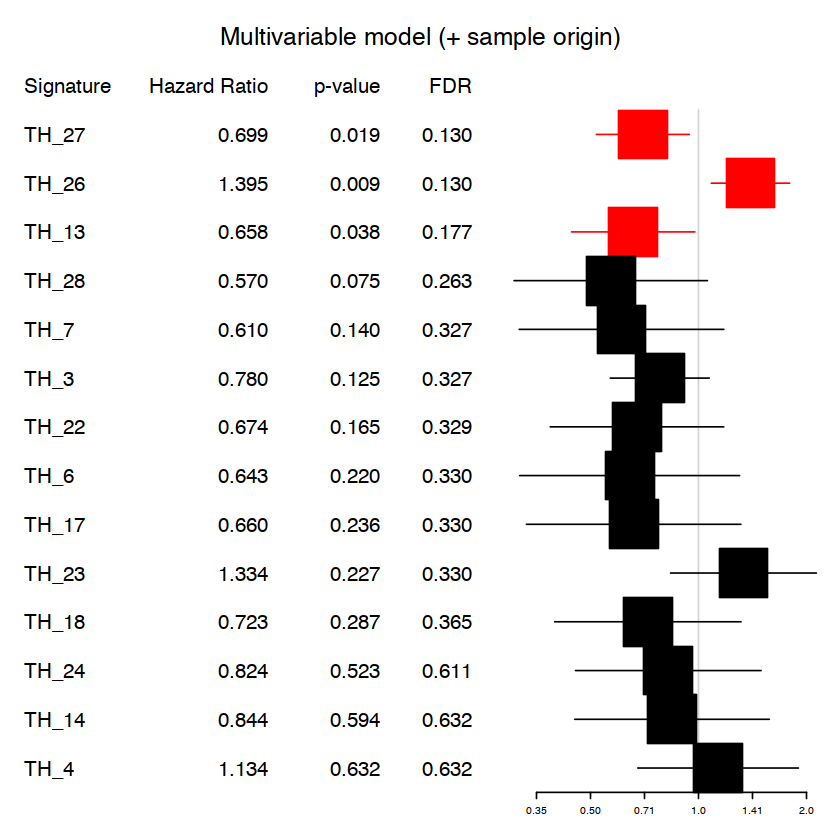

In [173]:
forest.fx(module_cox, "Multivariable model (+ sample origin)", 3, 14)

In [174]:
pdf(file = paste0(plotpath,"Multivar_forestplot_ordered.pdf"),
    width = 8, height = 12,
    useDingbats = FALSE, onefile = F)

forest.fx(module_cox, "Multivariable model (sample origin)", 3, 14)

dev.off()

GRID.VP.15::forestplot_margins 

pdf 
  2